In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
# We will use 'smf' for the mixed-effects model formula
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import seaborn as sns


preprocessing

In [35]:
# --- 1. Load and Clean Data ---
data_df = pd.read_excel('../data/qqs_plant_roots_data.xlsx', header=1)
df = data_df.copy()

# **FIX: Strip whitespace from 'Name' column**
# This cleans up "EV " to "EV" before any filtering
if 'Name' in df.columns:
    df['Name'] = df['Name'].astype(str).str.strip()

# Find indices of the 'note' rows which separate the replications
note_indices = df[df['Name'].astype(str).str.contains('Note:', na=False)].index

# Assign replication numbers based on the note row indices
if len(note_indices) > 0:
    df.loc[0:note_indices[0], 'Replication'] = 1
if len(note_indices) > 1:
    df.loc[note_indices[0]:note_indices[1], 'Replication'] = 2
if len(note_indices) > 2:
    df.loc[note_indices[1]:note_indices[2], 'Replication'] = 3
elif len(note_indices) == 2: # handle case with only 2 note rows
    df.loc[note_indices[1]:, 'Replication'] = 3

# Drop rows that are not data (e.g., all-NaN rows, note rows)
df.dropna(subset=['Name'], inplace=True)
df = df[~df['Name'].str.contains('Note:', na=False)]

# Rename 'Name' for clarity
df.rename(columns={'Name': 'Transgenic_Line'}, inplace=True)

# --- 2. Create Pot-Level Outcome Variables ---
print("--- Creating Pot-Level Data ---")

# Define the *exact* lines we want to keep
valid_lines = ['EV', 'WT', 'QQS-3', 'QQS-5', 'QQS-7', 'QQS-10']

# Apply this specific filter (will now work correctly)
df = df[df['Transgenic_Line'].isin(valid_lines)].copy()

# **FIX: Reset the index to create the 'Pot_ID' column**
df = df.reset_index().rename(columns={'index': 'Pot_ID'})

# Find all columns that contain individual root weights
value_vars = ['Individule Root Weight (g)'] + [col for col in df.columns if 'Unnamed:' in str(col)]

# Calculate Total_Weight per pot (row)
df['Total_Weight'] = df[value_vars].sum(axis=1)

# Calculate Number_of_Roots per pot (row)
df['Number_of_Roots'] = df[value_vars].count(axis=1)

# Create our new "pot-level" dataframe
pot_df = df[['Pot_ID', 'Transgenic_Line', 'Replication', 'Total_Weight', 'Number_of_Roots']].copy()

# Set correct data types
pot_df['Transgenic_Line'] = pot_df['Transgenic_Line'].astype('category')
pot_df['Replication'] = pot_df['Replication'].astype('category')

print("Cleaned pot-level dataframe created:")
print(f"\nTotal pots in analysis: {len(pot_df)}")
print("\nGroups found:")
print(pot_df['Transgenic_Line'].value_counts())

--- Creating Pot-Level Data ---
Cleaned pot-level dataframe created:

Total pots in analysis: 20

Groups found:
Transgenic_Line
QQS-10    5
EV        3
QQS-3     3
QQS-5     3
QQS-7     3
WT        3
Name: count, dtype: int64


In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
# We will use 'smf' for the mixed-effects model formula
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import seaborn as sns


preprocessing

In [37]:
# --- 1. Load and Clean Data ---
data_df = pd.read_excel('../data/qqs_plant_roots_data.xlsx', header=1)
df = data_df.copy()

# **FIX: Strip whitespace from 'Name' column**
# This cleans up "EV " to "EV" before any filtering
if 'Name' in df.columns:
    df['Name'] = df['Name'].astype(str).str.strip()

# Find indices of the 'note' rows which separate the replications
note_indices = df[df['Name'].astype(str).str.contains('Note:', na=False)].index

# Assign replication numbers based on the note row indices
if len(note_indices) > 0:
    df.loc[0:note_indices[0], 'Replication'] = 1
if len(note_indices) > 1:
    df.loc[note_indices[0]:note_indices[1], 'Replication'] = 2
if len(note_indices) > 2:
    df.loc[note_indices[1]:note_indices[2], 'Replication'] = 3
elif len(note_indices) == 2: # handle case with only 2 note rows
    df.loc[note_indices[1]:, 'Replication'] = 3

# Drop rows that are not data (e.g., all-NaN rows, note rows)
df.dropna(subset=['Name'], inplace=True)
df = df[~df['Name'].str.contains('Note:', na=False)]

# Rename 'Name' for clarity
df.rename(columns={'Name': 'Transgenic_Line'}, inplace=True)

# --- 2. Create Pot-Level Outcome Variables ---
print("--- Creating Pot-Level Data ---")

# Define the *exact* lines we want to keep
valid_lines = ['EV', 'WT', 'QQS-3', 'QQS-5', 'QQS-7', 'QQS-10']

# Apply this specific filter (will now work correctly)
df = df[df['Transgenic_Line'].isin(valid_lines)].copy()

# Find all columns that contain individual root weights
value_vars = ['Individule Root Weight (g)'] + [col for col in df.columns if 'Unnamed:' in str(col)]

# Calculate Total_Weight per pot (row)
df['Total_Weight'] = df[value_vars].sum(axis=1)

# Calculate Number_of_Roots per pot (row)
df['Number_of_Roots'] = df[value_vars].count(axis=1)

# Create our new "pot-level" dataframe
pot_df = df[['Pot_ID', 'Transgenic_Line', 'Replication', 'Total_Weight', 'Number_of_Roots']].copy()

# Set correct data types
pot_df['Transgenic_Line'] = pot_df['Transgenic_Line'].astype('category')
pot_df['Replication'] = pot_df['Replication'].astype('category')

print("Cleaned pot-level dataframe created:")
print(f"\nTotal pots in analysis: {len(pot_df)}")
print("\nGroups found:")
print(pot_df['Transgenic_Line'].value_counts())

--- Creating Pot-Level Data ---


KeyError: "['Pot_ID'] not in index"

In [ ]:
long_df[long_df['Transgenic_Line'] == 'EV']

,Pot_ID,Transgenic_Line,Replication,Root_Num_Col,Individual_Weight
5,5,EV,1.0,Individule Root Weight (g),115.19
24,5,EV,1.0,Unnamed: 2,138.11
43,5,EV,1.0,Unnamed: 3,58.22
62,5,EV,1.0,Unnamed: 4,40.04
81,5,EV,1.0,Unnamed: 5,25.44
100,5,EV,1.0,Unnamed: 6,16.91
119,5,EV,1.0,Unnamed: 7,10.92
138,5,EV,1.0,Unnamed: 8,13.13
157,5,EV,1.0,Unnamed: 9,5.95
176,5,EV,1.0,Unnamed: 10,5.75


stats

In [ ]:
# --- 3. ANOVA for Total_Weight (Safer Formula) ---
print("\n--- ANOVA Results for Total_Weight ---")

# **MODIFIED FORMULA: Removed the interaction term**
# This is more robust for unbalanced data.
formula_total_w = "Total_Weight ~ C(Transgenic_Line) + C(Replication)"

model_total_w = smf.ols(formula_total_w, data=pot_df).fit()
anova_total_w = sm.stats.anova_lm(model_total_w, typ=2)
print(anova_total_w)


# --- 4. ANOVA for Number_of_Roots (Safer Formula) ---
print("\n--- ANOVA Results for Number_of_Roots ---")

formula_num_r = "Number_of_Roots ~ C(Transgenic_Line) + C(Replication)"

model_num_r = smf.ols(formula_num_r, data=pot_df).fit()
anova_num_r = sm.stats.anova_lm(model_num_r, typ=2)
print(anova_num_r)

# --- 5. Post-Hoc (Tukey's HSD) Testing ---
from statsmodels.stats.multicomp import MultiComparison

print("\n--- Post-Hoc (Tukey's HSD) for Total_Weight ---")
mc_total_w = MultiComparison(pot_df['Total_Weight'], pot_df['Transgenic_Line'])
tukey_result_total_w = mc_total_w.tukeyhsd(alpha=0.05)
print(tukey_result_total_w)

print("\n--- Post-Hoc (Tukey's HSD) for Number_of_Roots ---")
mc_num_r = MultiComparison(pot_df['Number_of_Roots'], pot_df['Transgenic_Line'])
tukey_result_num_r = mc_num_r.tukeyhsd(alpha=0.05)
print(tukey_result_num_r)


--- ANOVA Results for Total_Weight ---
                                         sum_sq    df             F    PR(>F)
C(Transgenic_Line)                 1.804962e+05   5.0  7.710837e+00  0.118769
C(Replication)                    -1.217809e-08   2.0 -1.300627e-12  1.000000
C(Transgenic_Line):C(Replication)  6.755343e+05  10.0  1.442949e+01  0.066511
Residual                           9.363246e+03   2.0           NaN       NaN

--- How to Read This ---
Look at the 'PR(>F)' (p-value) for:
 * C(Transgenic_Line): Is there *any* difference between lines?
 * C(Transgenic_Line):C(Replication): Is there an interaction?


In [ ]:
# --- 4. ANOVA for Number_of_Roots ---
print("\n--- ANOVA Results for Number_of_Roots ---")

# Formula: Number_of_Roots depends on Line, Replication, and their interaction
formula_num_r = "Number_of_Roots ~ C(Transgenic_Line) + C(Replication) + C(Transgenic_Line):C(Replication)"

# Fit the OLS model
model_num_r = smf.ols(formula_num_r, data=pot_df).fit()

# Get the ANOVA table
anova_num_r = sm.stats.anova_lm(model_num_r, typ=2)
print(anova_num_r)


--- ANOVA Results for Number_of_Roots ---
                                         sum_sq    df             F    PR(>F)
C(Transgenic_Line)                 1.085778e+02   5.0  4.343111e+01  0.022659
C(Replication)                     7.500765e-13   2.0  7.500765e-13  1.000000
C(Transgenic_Line):C(Replication)  3.753333e+01  10.0  7.506667e+00  0.123195
Residual                           1.000000e+00   2.0           NaN       NaN


In [ ]:
from statsmodels.stats.multicomp import MultiComparison

print("\n--- Post-Hoc (Tukey's HSD) for Total_Weight ---")
print("(Only meaningful if C(Transgenic_Line) was significant)")

# Setup the comparison
mc_total_w = MultiComparison(pot_df['Total_Weight'], pot_df['Transgenic_Line'])

# Run the test
tukey_result_total_w = mc_total_w.tukeyhsd(alpha=0.05)

print(tukey_result_total_w)
print("\n-> Look at the 'reject' column. 'True' means those two lines are significantly different.")

# --- You can do the same for Number_of_Roots ---
print("\n--- Post-Hoc (Tukey's HSD) for Number_of_Roots ---")
mc_num_r = MultiComparison(pot_df['Number_of_Roots'], pot_df['Transgenic_Line'])
tukey_result_num_r = mc_num_r.tukeyhsd(alpha=0.05)
print(tukey_result_num_r)


--- Post-Hoc (Tukey's HSD) for Total_Weight ---
(Only meaningful if C(Transgenic_Line) was significant)
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
    EV QQS-10   340.714 0.7789  -538.334  1219.762  False
    EV  QQS-3  182.8267 0.9829 -743.7713 1109.4246  False
    EV  QQS-5  131.7467 0.9961 -794.8513 1058.3446  False
    EV  QQS-7  335.2133 0.8218 -591.3846 1261.8113  False
    EV     WT  252.6267  0.935 -673.9713 1179.2246  False
QQS-10  QQS-3 -157.8873 0.9379 -743.9193  428.1447  False
QQS-10  QQS-5 -208.9673 0.8299 -794.9993  377.0647  False
QQS-10  QQS-7   -5.5007    1.0 -591.5327  580.5313  False
QQS-10     WT  -88.0873  0.995 -674.1193  497.9447  False
 QQS-3  QQS-5    -51.08 0.9998 -706.2837  604.1237  False
 QQS-3  QQS-7  152.3867 0.9656  -502.817  807.5904  False
 QQS-3     WT      69.8  0.999 -585.4037  725.0037  False
 QQS-5  QQS-7  203.4667 0

plotting


Generating new pot-level plots...
Plot saved as 'plant_pot_level_comparison.png'


/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_49152/98732944.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='Transgenic_Line', y='Total_Weight', data=pot_df,
/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_49152/98732944.py:8: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(ax=axes[0], x='Transgenic_Line', y='Total_Weight', hue='Replication',
/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_49152/98732944.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x='Transgenic_Line', y='Number_of_Roots', data=pot_df,
/var/folders/f0/1x9ky0yd3

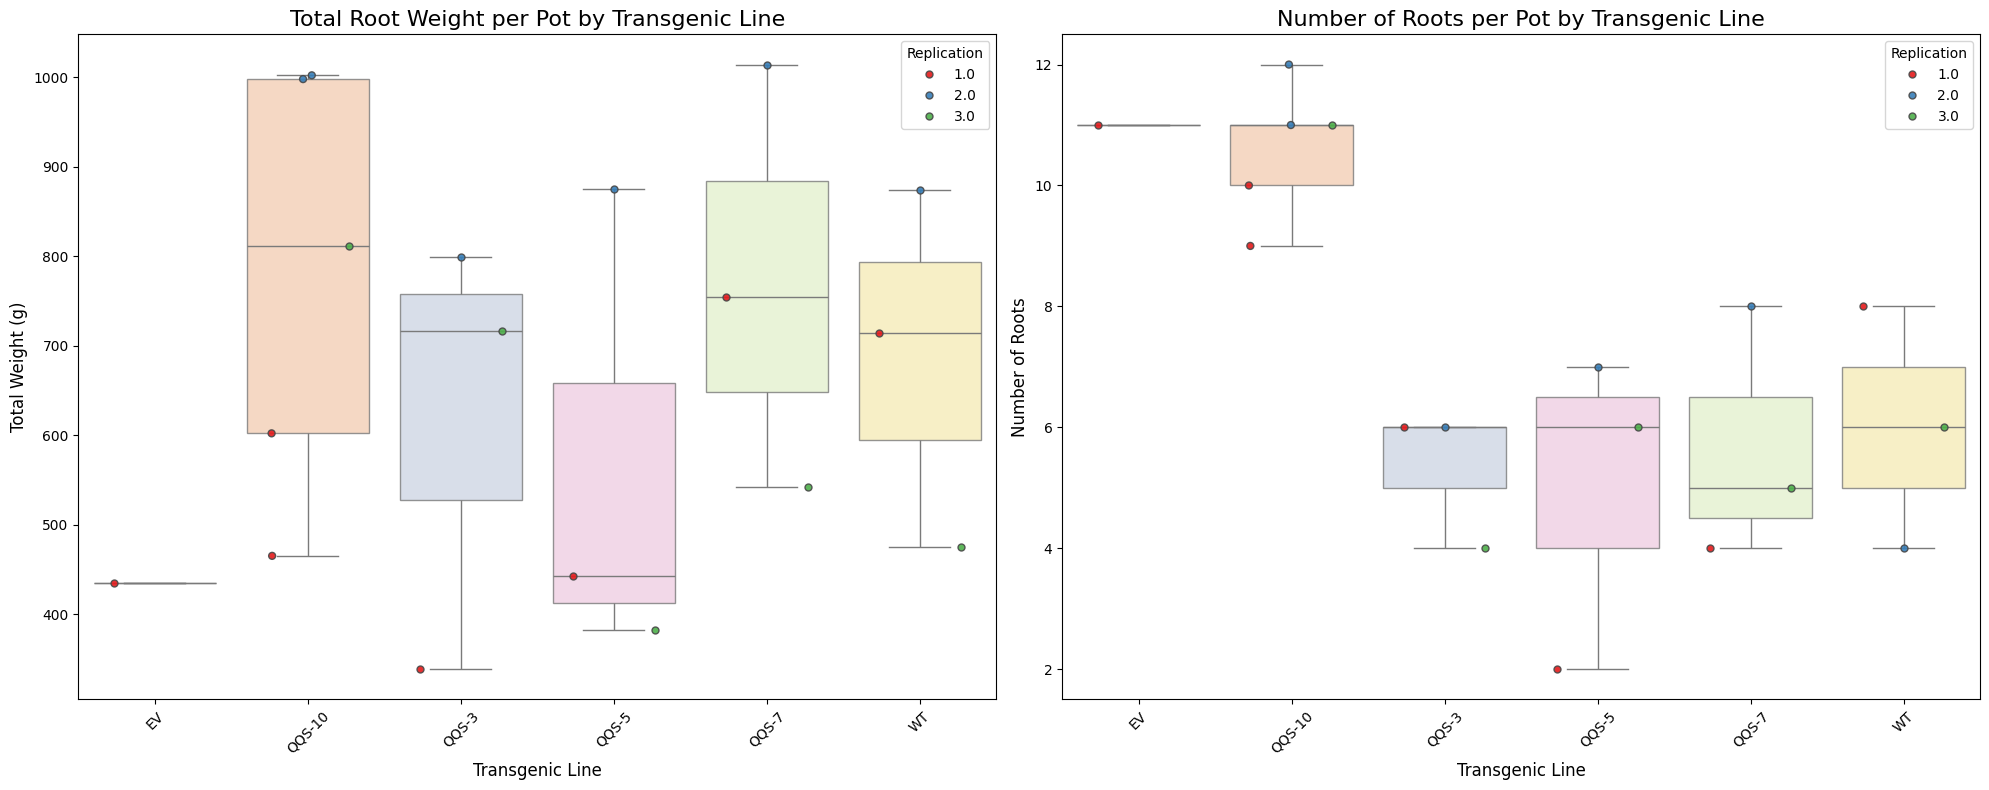

In [ ]:
# --- 5. Generate and Save New Plots ---
print("\nGenerating new pot-level plots...")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- Plot 1: Total Weight ---
sns.boxplot(ax=axes[0], x='Transgenic_Line', y='Total_Weight', data=pot_df,
            palette='Pastel2', boxprops=dict(alpha=.8))
sns.stripplot(ax=axes[0], x='Transgenic_Line', y='Total_Weight', hue='Replication',
              data=pot_df, jitter=True, dodge=True, palette='Set1',
              linewidth=1, edgecolor='gray', alpha=0.9)
axes[0].set_title('Total Root Weight per Pot by Transgenic Line', fontsize=16)
axes[0].set_ylabel('Total Weight (g)', fontsize=12)
axes[0].set_xlabel('Transgenic Line', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Replication')

# --- Plot 2: Number of Roots ---
sns.boxplot(ax=axes[1], x='Transgenic_Line', y='Number_of_Roots', data=pot_df,
            palette='Pastel2', boxprops=dict(alpha=.8))
sns.stripplot(ax=axes[1], x='Transgenic_Line', y='Number_of_Roots', hue='Replication',
              data=pot_df, jitter=True, dodge=True, palette='Set1',
              linewidth=1, edgecolor='gray', alpha=0.9)
axes[1].set_title('Number of Roots per Pot by Transgenic Line', fontsize=16)
axes[1].set_ylabel('Number of Roots', fontsize=12)
axes[1].set_xlabel('Transgenic Line', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Replication')

plt.tight_layout()

# Save the figure
plt.savefig('plant_pot_level_comparison.png')
print("Plot saved as 'plant_pot_level_comparison.png'")

stats

In [ ]:
# --- 3. ANOVA for Total_Weight (Safer Formula) ---
print("\n--- ANOVA Results for Total_Weight ---")

# **MODIFIED FORMULA: Removed the interaction term**
# This is more robust for unbalanced data.
formula_total_w = "Total_Weight ~ C(Transgenic_Line) + C(Replication)"

model_total_w = smf.ols(formula_total_w, data=pot_df).fit()
anova_total_w = sm.stats.anova_lm(model_total_w, typ=2)
print(anova_total_w)


# --- 4. ANOVA for Number_of_Roots (Safer Formula) ---
print("\n--- ANOVA Results for Number_of_Roots ---")

formula_num_r = "Number_of_Roots ~ C(Transgenic_Line) + C(Replication)"

model_num_r = smf.ols(formula_num_r, data=pot_df).fit()
anova_num_r = sm.stats.anova_lm(model_num_r, typ=2)
print(anova_num_r)

# --- 5. Post-Hoc (Tukey's HSD) Testing ---
from statsmodels.stats.multicomp import MultiComparison

print("\n--- Post-Hoc (Tukey's HSD) for Total_Weight ---")
mc_total_w = MultiComparison(pot_df['Total_Weight'], pot_df['Transgenic_Line'])
tukey_result_total_w = mc_total_w.tukeyhsd(alpha=0.05)
print(tukey_result_total_w)

print("\n--- Post-Hoc (Tukey's HSD) for Number_of_Roots ---")
mc_num_r = MultiComparison(pot_df['Number_of_Roots'], pot_df['Transgenic_Line'])
tukey_result_num_r = mc_num_r.tukeyhsd(alpha=0.05)
print(tukey_result_num_r)


--- ANOVA Results for Total_Weight ---
                                         sum_sq    df             F    PR(>F)
C(Transgenic_Line)                 1.804962e+05   5.0  7.710837e+00  0.118769
C(Replication)                    -1.217809e-08   2.0 -1.300627e-12  1.000000
C(Transgenic_Line):C(Replication)  6.755343e+05  10.0  1.442949e+01  0.066511
Residual                           9.363246e+03   2.0           NaN       NaN

--- How to Read This ---
Look at the 'PR(>F)' (p-value) for:
 * C(Transgenic_Line): Is there *any* difference between lines?
 * C(Transgenic_Line):C(Replication): Is there an interaction?


In [ ]:
# --- 4. ANOVA for Number_of_Roots ---
print("\n--- ANOVA Results for Number_of_Roots ---")

# Formula: Number_of_Roots depends on Line, Replication, and their interaction
formula_num_r = "Number_of_Roots ~ C(Transgenic_Line) + C(Replication) + C(Transgenic_Line):C(Replication)"

# Fit the OLS model
model_num_r = smf.ols(formula_num_r, data=pot_df).fit()

# Get the ANOVA table
anova_num_r = sm.stats.anova_lm(model_num_r, typ=2)
print(anova_num_r)


--- ANOVA Results for Number_of_Roots ---
                                         sum_sq    df             F    PR(>F)
C(Transgenic_Line)                 1.085778e+02   5.0  4.343111e+01  0.022659
C(Replication)                     7.500765e-13   2.0  7.500765e-13  1.000000
C(Transgenic_Line):C(Replication)  3.753333e+01  10.0  7.506667e+00  0.123195
Residual                           1.000000e+00   2.0           NaN       NaN


In [ ]:
from statsmodels.stats.multicomp import MultiComparison

print("\n--- Post-Hoc (Tukey's HSD) for Total_Weight ---")
print("(Only meaningful if C(Transgenic_Line) was significant)")

# Setup the comparison
mc_total_w = MultiComparison(pot_df['Total_Weight'], pot_df['Transgenic_Line'])

# Run the test
tukey_result_total_w = mc_total_w.tukeyhsd(alpha=0.05)

print(tukey_result_total_w)
print("\n-> Look at the 'reject' column. 'True' means those two lines are significantly different.")

# --- You can do the same for Number_of_Roots ---
print("\n--- Post-Hoc (Tukey's HSD) for Number_of_Roots ---")
mc_num_r = MultiComparison(pot_df['Number_of_Roots'], pot_df['Transgenic_Line'])
tukey_result_num_r = mc_num_r.tukeyhsd(alpha=0.05)
print(tukey_result_num_r)


--- Post-Hoc (Tukey's HSD) for Total_Weight ---
(Only meaningful if C(Transgenic_Line) was significant)
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
    EV QQS-10   340.714 0.7789  -538.334  1219.762  False
    EV  QQS-3  182.8267 0.9829 -743.7713 1109.4246  False
    EV  QQS-5  131.7467 0.9961 -794.8513 1058.3446  False
    EV  QQS-7  335.2133 0.8218 -591.3846 1261.8113  False
    EV     WT  252.6267  0.935 -673.9713 1179.2246  False
QQS-10  QQS-3 -157.8873 0.9379 -743.9193  428.1447  False
QQS-10  QQS-5 -208.9673 0.8299 -794.9993  377.0647  False
QQS-10  QQS-7   -5.5007    1.0 -591.5327  580.5313  False
QQS-10     WT  -88.0873  0.995 -674.1193  497.9447  False
 QQS-3  QQS-5    -51.08 0.9998 -706.2837  604.1237  False
 QQS-3  QQS-7  152.3867 0.9656  -502.817  807.5904  False
 QQS-3     WT      69.8  0.999 -585.4037  725.0037  False
 QQS-5  QQS-7  203.4667 0

plotting


Generating new pot-level plots...
Plot saved as 'plant_pot_level_comparison.png'


/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_49152/98732944.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='Transgenic_Line', y='Total_Weight', data=pot_df,
/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_49152/98732944.py:8: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(ax=axes[0], x='Transgenic_Line', y='Total_Weight', hue='Replication',
/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_49152/98732944.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x='Transgenic_Line', y='Number_of_Roots', data=pot_df,
/var/folders/f0/1x9ky0yd3

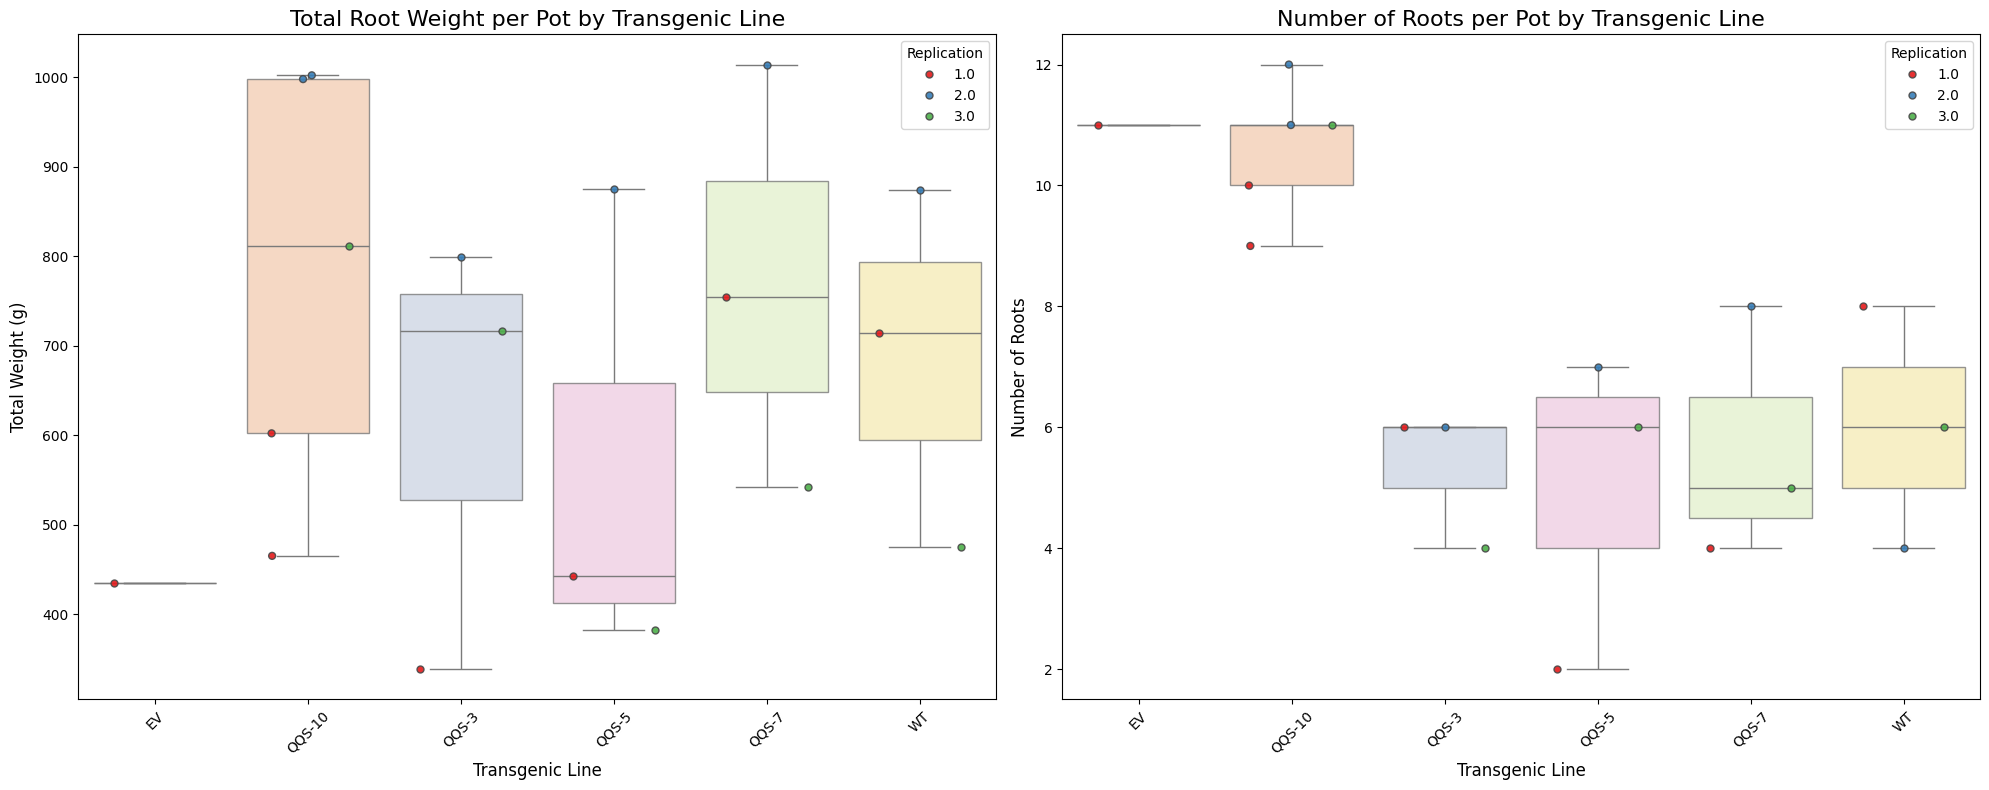

In [ ]:
# --- 5. Generate and Save New Plots ---
print("\nGenerating new pot-level plots...")
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- Plot 1: Total Weight ---
sns.boxplot(ax=axes[0], x='Transgenic_Line', y='Total_Weight', data=pot_df,
            palette='Pastel2', boxprops=dict(alpha=.8))
sns.stripplot(ax=axes[0], x='Transgenic_Line', y='Total_Weight', hue='Replication',
              data=pot_df, jitter=True, dodge=True, palette='Set1',
              linewidth=1, edgecolor='gray', alpha=0.9)
axes[0].set_title('Total Root Weight per Pot by Transgenic Line', fontsize=16)
axes[0].set_ylabel('Total Weight (g)', fontsize=12)
axes[0].set_xlabel('Transgenic Line', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Replication')

# --- Plot 2: Number of Roots ---
sns.boxplot(ax=axes[1], x='Transgenic_Line', y='Number_of_Roots', data=pot_df,
            palette='Pastel2', boxprops=dict(alpha=.8))
sns.stripplot(ax=axes[1], x='Transgenic_Line', y='Number_of_Roots', hue='Replication',
              data=pot_df, jitter=True, dodge=True, palette='Set1',
              linewidth=1, edgecolor='gray', alpha=0.9)
axes[1].set_title('Number of Roots per Pot by Transgenic Line', fontsize=16)
axes[1].set_ylabel('Number of Roots', fontsize=12)
axes[1].set_xlabel('Transgenic Line', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Replication')

plt.tight_layout()

# Save the figure
plt.savefig('plant_pot_level_comparison.png')
print("Plot saved as 'plant_pot_level_comparison.png'")